<a href="https://colab.research.google.com/github/mariamhamid/ML-Projects-Unsupervised/blob/main/chest_xray_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
import kagglehub
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


In [2]:
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

data_dir = os.path.join(path, "chest_xray")

img_size = (150, 150)
batch_size = 32

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, "train"),
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, "val"),
    image_size=img_size,
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, "test"),
    image_size=img_size,
    batch_size=batch_size
)


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [4]:
def normalize_img(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # scale pixel values to [0,1]
    return image, label


train_ds = train_ds.map(normalize_img)
val_ds = val_ds.map(normalize_img)
test_ds = test_ds.map(normalize_img)


In [5]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Class names: ['NORMAL', 'PNEUMONIA']


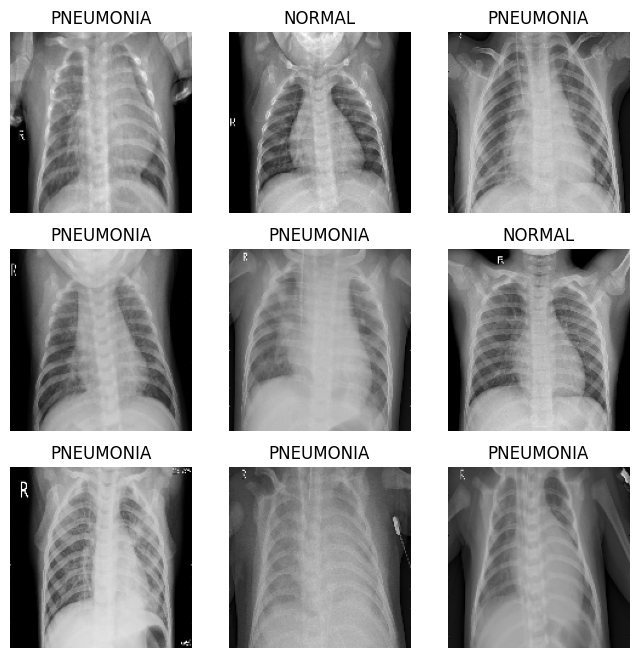

In [7]:
class_names = ['NORMAL', 'PNEUMONIA']
print("Class names:", class_names)

plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap="gray")
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")
plt.show()


In [14]:
import numpy as np

# Collect all labels in training set
all_labels = np.concatenate([labels.numpy() for images, labels in train_ds], axis=0)

# Count each class
unique, counts = np.unique(all_labels, return_counts=True)
for u, c in zip(unique, counts):
    print(f"{class_names[u]}: {c} images")


NORMAL: 1341 images
PNEUMONIA: 3875 images


In [15]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(150,150,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


In [16]:
num_classes = 2
model = models.Sequential([
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 73984)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     4,735,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,791,490 (18.28 MB)

 Trainable params: 4,791,490 (18.28 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.7388 - loss: 0.6043 - val_accuracy: 0.7500 - val_loss: 0.7014
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8607 - loss: 0.3228 - val_accuracy: 0.8750 - val_loss: 0.6726
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8822 - loss: 0.2687 - val_accuracy: 0.8125 - val_loss: 0.7058
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8986 - loss: 0.2384 - val_accuracy: 0.7500 - val_loss: 0.5527
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9066 - loss: 0.2250 - val_accuracy: 0.8750 - val_loss: 0.6741
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9135 - loss: 0.2275 - val_accuracy: 0.9375 - val_loss: 0.5776
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9290 - loss: 0.1965 - val_accuracy: 0.8750 - val_loss: 0.5204
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9348 - loss: 0.1726 - val_accu

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9430 - loss: 0.1685 - val_accuracy: 0.6250 - val_loss: 2.3861
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9224 - loss: 0.2196 - val_accuracy: 0.6250 - val_loss: 0.7818
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9470 - loss: 0.1554 - val_accuracy: 0.6250 - val_loss: 0.8582
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9407 - loss: 0.1688 - val_accuracy: 0.6875 - val_loss: 0.7633
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9468 - loss: 0.1508 - val_accuracy: 0.8750 - val_loss: 0.3822
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9414 - loss: 0.1543 - val_accuracy: 0.8125 - val_loss: 0.2771
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9295 - loss: 0.1811 - val_accuracy: 0.6875 - val_loss: 0.6516
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9496 - loss: 0.1449 - val_accu

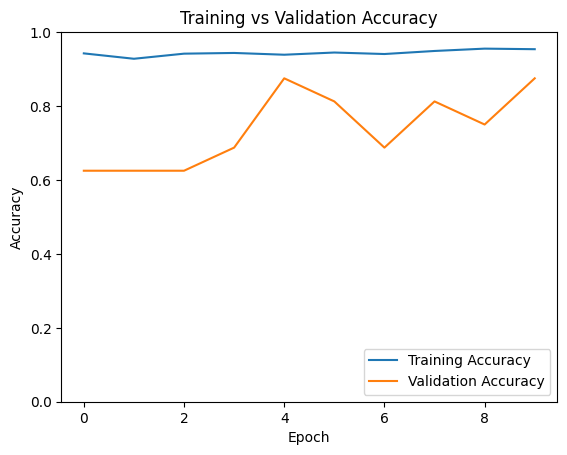

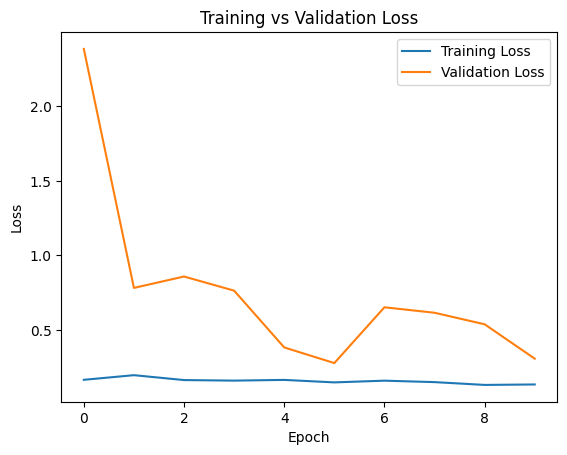

20/20 - 3s - 136ms/step - accuracy: 0.8894 - loss: 0.2959

Test Accuracy: 0.8894230723381042
Test Loss: 0.29586392641067505


In [18]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')
plt.show()

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds, verbose=2)  # use test_ds if dataset, or test_images/test_labels if arrays
print("\nTest Accuracy:", test_acc)
print("Test Loss:", test_loss)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


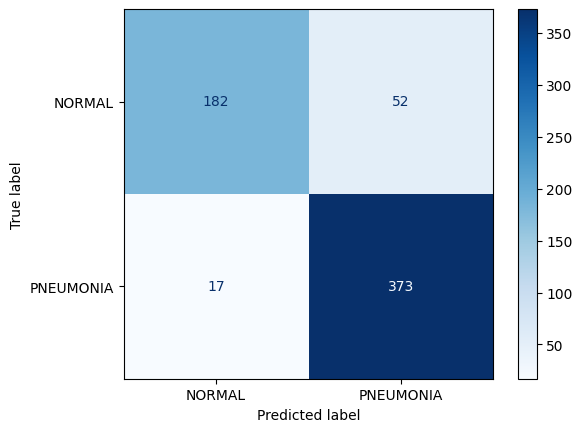


Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.91      0.78      0.84       234
   PNEUMONIA       0.88      0.96      0.92       390

    accuracy                           0.89       624
   macro avg       0.90      0.87      0.88       624
weighted avg       0.89      0.89      0.89       624



In [19]:
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds), axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

The previous cell `A1zUBUwg-CA2` contains the correct model definition. The error in this cell was a `SyntaxError` due to an incorrect format for the `input_shape` argument in the `Dense` layer.